In [1]:
#%matplotlib widget
from time import time
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from functools import lru_cache
import numpy as np
from scipy import ndimage
from itertools import islice

In [2]:
# blur/focus based
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def tile(im, nrows=1, ncolumns=6, debugging=False):
    M = im.shape[0] // nrows
    N = im.shape[1] // ncolumns
    rows = []
    for x in range(0, M*nrows,M):
        row = []
        for y in range(0,N*ncolumns,N):
            row.append(im[x:x+M,y:y+N])
        rows.append(row)
    if debugging:
        width = 3.0
        height = width/im.shape[1]*im.shape[0]
        fig = plt.figure(figsize = (width,height))
        gs = gridspec.GridSpec(nrows, ncolumns, figure=fig)
        gs.update(wspace=0.0, hspace=0.0)
        for r in range(nrows):
            for c in range(ncolumns):
                ax = fig.add_subplot(gs[r, c])
                ax.imshow(rows[r][c], vmin=0, vmax=im.max())
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

        plt.show()
            
    return rows

flatten = lambda l: [item for sublist in l for item in sublist]

def via_variance_of_laplacian(f):
    image = f['_']
    tiles = tile(image, nrows=3, ncolumns=1)
    return [variance_of_laplacian(i) for i in flatten(tiles)]

In [3]:
# Optical Flow Based
def fix_perspective(im, debugging=False):
    h, w = im.shape
    assert (w, h) == (640, 160) # this is tuned for a very specific crop and dashcam position
    left = 60 # left-right adjustment
    top = 5
    bottom = 30
    if debugging:
        src_rect = np.array([
            [245, originy+top],   [370, originy+top],
            [0, 125],   [600, 100]],
            dtype = "float32")
        dst_rect = np.array([
            [80-left, 0],    [330-left, 0],
            [108-left, 840],  [320-left, 800]],
            dtype = "float32")
        M = cv2.getPerspectiveTransform(src_rect, dst_rect)
        print(repr(M))
    else:
        M = np.array(
           [[-5.79976346e+00, -2.25571424e+01,  1.92672659e+03],
            [-1.81898940e-14, -1.56260338e+02,  3.90650844e+03],
            [ 5.42171076e-05, -1.56819369e-01,  1.00000000e+00]])
    dst = cv2.warpPerspective(im,M,(300,840-bottom))
    if debugging:
        plt.rcParams['figure.figsize'] = [20, 12]
        plt.imshow(im)
        plt.show()
        plt.imshow(dst)
        plt.show()
    return dst

def optical_flow(image, image_next, frame, debugging=False):
   
    # params for ShiTomasi corner detection
    feature_params = dict(
        maxCorners = 100,
        qualityLevel = 0.007,
        minDistance = 20,
        blockSize = 9,
        #useHarrisDetector = True,
        )

    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize  = (15,15),
        maxLevel = 1,
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
        )
    
    p0 = cv2.goodFeaturesToTrack(image, mask = None, **feature_params)
    p1, st, err = cv2.calcOpticalFlowPyrLK(image, image_next, p0, None, **lk_params)
    
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    
    # setup zenith
    shape=image.shape
    #ys,xs = np.indices(shape)
    x_offset = shape[1] // 2
    y_offset = int(originy)
    
    img = image_next.copy()

    df = pd.DataFrame()
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        x1, y1 = old.ravel()
        x2, y2 = new.ravel()
        
        dx, dy = (x2-x1), (y2-y1)
        if dx == 0.0:
            dx = 0.00001 #prevent divide by zero
        Vf_slope = dy/dx
        Vf_mag = (dx**2 + dy**2)**0.5
        
        if Vf_mag < 2.5 or Vf_mag>140:
            # absurd
            continue

        df.loc[i,'|Vf|'] = Vf_mag
        df.loc[i,'Vf_slope'] = Vf_slope
        
        right_direction = y2>y1 and abs(Vf_slope) > 3 # down and steep
        df.loc[i,'right_direction'] = right_direction
        
        if right_direction:
            color=255
            df.loc[i,'good'] = True
        else:
            color=130
            df.loc[i,'good'] = False
        
        if debugging:
            img = cv2.arrowedLine(img, (int(x1),int(y1)),(int(x2),int(y2)), color, tipLength=.3)
            img = cv2.circle(img,(int(x1),int(y1)),2,color, -1)
    
    if len(df) != 0:
        # filter out noisy "small" flow vectors
        Vf_max = df[df['good']==True]['|Vf|'].max()
        df.loc[df['|Vf|']<Vf_max*.45,'good'] = False
    
    if debugging:
        if len(df) == 0:
            print("no useful points")
        else:
            display(df.sort_values(by='|Vf|'))       
            bins = list(range(0,101,10))
            plt.rcParams['figure.figsize'] = [20, 5]
            df['|Vf|'].hist(bins=bins)
            df[df['good']==True]['|Vf|'].hist(bins=bins)
            plt.show()

        plt.rcParams['figure.figsize'] = [20, 12]
        plt.imshow(img)
        plt.show()

    if len(df) == 0:
        return [np.nan, np.nan]
    else:
        return [
            df.loc[df['good'],'|Vf|'].mean(),
            df.loc[df['right_direction'],'|Vf|'].std(),
            ]

def via_lk_optical_flow(f):
    image, image_next  = f['_'], f['1']
    return optical_flow(image, image_next, frame=f)

In [4]:
# Process frames
def frames():
    vidcap = cv2.VideoCapture('../data/train.mp4')
    while True:
        success, image = vidcap.read()
        if success:
            yield {'orig': image, '_': image, 'xs':[]}
        else:
            return

originy=None
def crop(image, bottom=100, top=220):
    # take of top and bottom
    global originy
    originy = image.shape[0] / 2 - top
    return image[top:image.shape[0] - bottom,:]

def crop_frames(frames):
    for f in frames:
        f['_'] = crop(f['_'])
        yield f

def bw_frames(frames):
    for f in frames:
        f['_'] = cv2.cvtColor(f['_'],cv2.COLOR_BGR2GRAY)
        yield f 

def perspec_frames(frames):
    for f in frames:
        f['_'] = fix_perspective(f['_'])
        yield f
        
def diff_frames(frames):
    #from skimage.measure import compare_ssim
    for f in frames:
        f['diff'] = cv2.subtract(f['_'],f['1'])
        #(score, diff) = compare_ssim(grayA, grayB, full=True)
        yield f

def adjacent(frames):
    # add "lookahead" in keys '1', '2', ...
    # repeats at the end to keep length len
    fs = list()
    count = 1
    
    def _updated_f():
        f = fs.pop(0)
        f.update({str(n+1):f['_'] for n, f in enumerate(fs)})
        return f 
        
    for f in frames:
        fs.append(f)
        if len(fs) > count:
            yield _updated_f()

    for _ in range(count):
        fs.append(f)
        yield _updated_f()
        
def print_keys(frames):
    for f in frames:
        print(repr(list(f.keys())))
        yield f

def view_frames(frames):
    for f in frames:
        for k in f.keys():
            if k == 'xs':
                continue
            cv2.imshow(k,f[k])
        try:
            cv2.waitKey(0)
        except KeyboardInterrupt:
            cv2.destroyAllWindows()
            print("Stopping early, KeyboardInterrupt")
            return
        yield f
    cv2.destroyAllWindows()

def analyze_frames(via):
    def analyze(frames):
        for f in frames:
            f['xs'] += via(f)
            yield f
    return analyze

class FeatureExtractor():
    def __init__(self, frames_generator_maker):
        self._frames = frames_generator_maker
        self._steps = []
    def add_step(self, step):
        if callable(step):
            self._steps.append(step)
    def __iter__(self):
        pipeline = self._frames()
        for s in self._steps:
            pipeline = s(pipeline)
        return pipeline
    def _pprogress(self, count, force=False):
        if force or time()-self._last>30:
            self._last = time()
            print(f"{count+1} processed in {(time()-self._start)/60:2.1f} minutes")
    def extract_features(self):
        self._start = time()
        self._last = self._start
        X = []
        i=0
        for i, f in enumerate(self):
            X.append(f['xs'])
            self._pprogress(i)
        self._pprogress(i,True)
        
        return X


In [5]:
fe = FeatureExtractor(frames)
#fe.add_step(lambda g: islice(g, 17500, 20400, 1)) # limit frames (start, stop, step)
#fe.add_step(lambda g: islice(g, 10)) # limit frames (start, stop, step)
fe.add_step(crop_frames)
fe.add_step(bw_frames)
fe.add_step(perspec_frames)
fe.add_step(adjacent)
fe.add_step(analyze_frames(via_lk_optical_flow))
fe.add_step(analyze_frames(via_variance_of_laplacian))

#fe.add_step(print_keys)
#fe.add_step(diff_frames)
#fe.add_step(view_frames)

xs = fe.extract_features()

548 processed in 0.5 minutes
1362 processed in 1.0 minutes
1899 processed in 1.5 minutes
2787 processed in 2.0 minutes
3670 processed in 2.5 minutes
4558 processed in 3.0 minutes
5345 processed in 3.5 minutes
5974 processed in 4.0 minutes
6530 processed in 4.5 minutes
7167 processed in 5.0 minutes
7789 processed in 5.5 minutes
8333 processed in 6.0 minutes
8968 processed in 6.5 minutes
9537 processed in 7.0 minutes
10058 processed in 7.5 minutes
10581 processed in 8.0 minutes
11073 processed in 8.5 minutes
11559 processed in 9.0 minutes
12080 processed in 9.5 minutes
12643 processed in 10.0 minutes
13265 processed in 10.5 minutes
13767 processed in 11.0 minutes
14207 processed in 11.5 minutes
14804 processed in 12.0 minutes
15280 processed in 12.5 minutes
15921 processed in 13.0 minutes
16584 processed in 13.5 minutes
17294 processed in 14.0 minutes
17993 processed in 14.5 minutes
18582 processed in 15.0 minutes
19238 processed in 15.5 minutes
19759 processed in 16.0 minutes
20217 proc

In [6]:
def shuffle_time_in_chunks(df, n):
    """Break df into n-lengths mini dfs"""
    assert len(df) >= n*10, "doesn't meet minimum number of chunks"
    assert (len(df) % n) == 0, "all chunks equal size"
    
    chunk_count = len(df[0]) // n
    chunks = []
    for x in range(0, len(df), n):
        chunks.append(df[x:x + n])
    random.shuffle(chunks)
    print(f"Using {len(chunks):0d} chunks")
    return pd.concat(chunks, axis=0)   

In [7]:
y = pd.read_csv('../data/train.txt', header=None)
X = pd.DataFrame(xs)

X.fillna(method='pad', inplace=True)

Xy = X.copy(deep=True)
Xy['y'] = y

chunksize = 60
chunksize = 2040 # ten chunks
chunksize = 204*2 # 50
Xy = shuffle_time_in_chunks(Xy, chunksize)
Xy

Using 50 chunks


,0,1,2,3,4,y
8976,37.939030,11.734529,8.477182,6.197612,29.633070,9.240580
8977,18.326478,7.135855,7.778968,4.895791,25.230638,9.232567
8978,26.976567,11.720195,8.892235,5.046366,24.315404,9.204657
8979,33.030485,14.556637,9.965051,4.922512,22.105021,9.187174
8980,22.695123,9.799171,11.680113,5.846032,20.013317,9.187931
...,...,...,...,...,...,...
12235,6.884770,1.940867,5.430654,8.989505,23.413814,4.370065
12236,30.170602,8.308164,6.015691,9.213469,23.214639,4.389577
12237,19.212062,6.221630,5.548379,8.584481,22.009936,4.319826
12238,17.929493,4.703052,5.839743,9.079062,22.161329,4.253576


In [94]:
def find_testcount(test_df, fraction_testset=0.3):
    chunks = 1
    while True:
        chunks += 1
        testcount = chunksize * chunks
        if testcount/len(test_df)>fraction_testset:
            break
    print(f"using testcount = {testcount}")
    return testcount
    
testcount = find_testcount(Xy, .43)

Xy_train, Xy_test = train_test_split(Xy, test_size=testcount,shuffle=False)
Xy_train, Xy_test = Xy_train.copy(deep=True), Xy_test.copy(deep=True)
print("Percent test    =", testcount/len(Xy))

using testcount = 8976
Percent test    = 0.44


In [165]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor

m_dum = DummyRegressor(strategy='mean')

m_ensemble = StackingRegressor([
   ('svr', SVR(C=.3)),
   ('rf', RandomForestRegressor()),
   #('mlp', MLPRegressor(shuffle=False, alpha=0.1)),
   ])

pipe = Pipeline([
    ('scale', StandardScaler()),
    #('poly', PolynomialFeatures(interaction_only=False, include_bias=False)),
    #'reduce_dims', PCA(n_components=4)),
    #('svr', SVR(C=2)),
    #('rf', RandomForestRegressor()),
    #'mlp', MLPRegressor(shuffle=False, alpha=0.1)),
    #('br', BayesianRidge()),
    ('stack', m_ensemble),
    #('lin', LinearRegression()),
    ])



# # Training classifiers
# reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
# reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
# reg3 = LinearRegression()
# ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
# BaysianRidge
# MLP NN

from sklearn.model_selection import GridSearchCV
parameters = {
    'svr__C':[.01, .1, .3, .9, 2, 4, 10, 15, 20, 30],
    #'svr__C':[10, 20, 30, 40, 70, 120],
    #'mlp__alpha':[0.0001, 0.001, 0.01],
    #'svr__C':[.3],RandomForestRegressor
    #'svr__gamma':[0.006/4, 0.006/2,0.006,0.006*2],
    }
grid = GridSearchCV(pipe, parameters, verbose=10, n_jobs=5, cv=5)

m_real = pipe


In [166]:
m_dum.fit(Xy_train[X.columns], Xy_train['y'])
m_real.fit(Xy_train[X.columns], Xy_train['y'])
try:
    print(m_real.best_estimator_)
except:
    print(m_real)

Pipeline(steps=[('scale', StandardScaler()),
                ('stack',
                 StackingRegressor(estimators=[('svr', SVR(C=0.3)),
                                               ('rf',
                                                RandomForestRegressor())]))])


In [167]:
# recreate full original df
Xy_test.loc[:,'is_test'] = True
Xy_train.loc[:,'is_test'] = False
Xy2 = pd.concat([Xy_test,Xy_train]).sort_index()

# get predictions
Xy2['dum'] = m_dum.predict(Xy2[X.columns])
Xy2['pred'] = m_real.predict(Xy2[X.columns])

# for convience
Xy2_test_ix = Xy2['is_test'] == True
Xy2_train_ix = Xy2['is_test'] == False

# smooth based on distribution of acceleration in training set
idea use kalman filter based 

In [168]:
# tune a kalman filter
from pykalman import KalmanFilter
em_vars = [
     #'transition_covariance',
     'observation_covariance',
     'initial_state_mean', 'initial_state_covariance']

T = np.array([[.0009]]) # smaller is more resistance to acceleration

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=T)
kf_tuned = kf.em(Xy2.loc[Xy2_train_ix,'y'].values, n_iter=0, em_vars=em_vars)

In [169]:
# apply kalman
Xy2.loc[Xy2_test_ix,'pred_kf'] = kf_tuned.smooth(Xy2.loc[Xy2_test_ix,'pred'].values)[0]

In [170]:
# never below 0
Xy2.loc[Xy2['pred_kf']<0.0,'pred_kf'] = 0.0

In [171]:
Xy2

,0,1,2,3,4,y,is_test,dum,pred,pred_kf
0,58.673446,22.822471,1.394652,8.739382,9.827107,28.105569,False,12.950284,25.082570,NaN
1,59.147177,23.066120,2.136085,5.949480,14.184612,28.105569,False,12.950284,24.901653,NaN
2,55.560619,19.984714,3.148097,3.898913,20.263005,28.106527,False,12.950284,24.693951,NaN
3,73.675072,28.787178,3.913924,1.486788,20.116366,28.130404,False,12.950284,25.015395,NaN
4,35.566856,12.769915,3.834851,2.720604,18.320774,28.109243,False,12.950284,21.767023,NaN
...,...,...,...,...,...,...,...,...,...,...
20395,7.681011,2.414488,10.993494,25.022707,20.235383,2.329180,True,12.950284,2.051195,5.286523
20396,9.685960,2.993004,13.557630,27.158036,21.719475,2.289795,True,12.950284,2.257226,5.282815
20397,31.417940,4.465445,12.076505,24.605623,20.842427,2.292917,True,12.950284,11.673886,5.281830
20398,5.376523,1.690446,14.525258,28.060961,23.162158,2.260600,True,12.950284,1.533704,5.275093


In [172]:
Xy2['0_kf'] = kf_tuned.smooth(Xy2[0].values)[0]
Xy2['0_kf'] *= Xy2['y'].mean()/Xy2['0_kf'].mean()

Xy2['0_scaled'] = Xy2[0] * Xy2['y'].mean()/Xy2[0].mean()

Xy2['1_kf'] = kf_tuned.smooth(Xy2[1].values)[0]

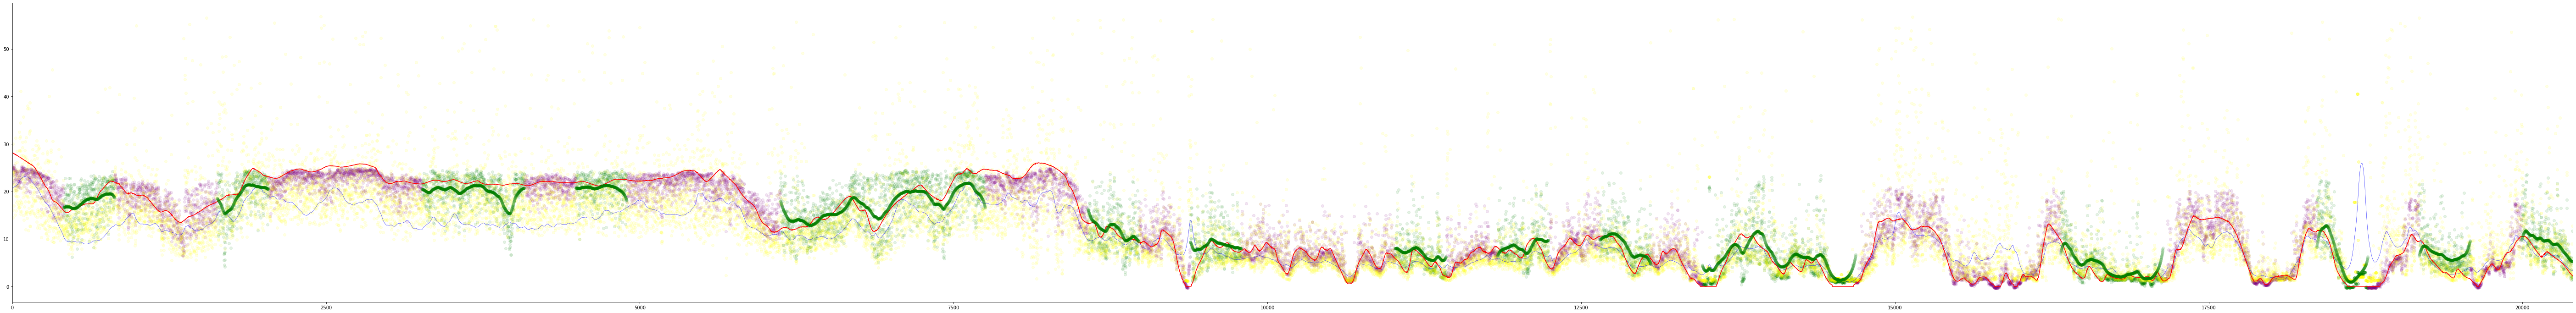

In [173]:
plt.rcParams['figure.figsize'] = [100, 12]
plt.gca().set_xlim((0,len(Xy2)))
def plot_Xy2(ix_mask, column, **kwargs):
    if ix_mask is None:
        df = Xy2.loc[:,column]
    else:
        df = Xy2.loc[ix_mask, column]
    plt.plot(df.index, df.values, **kwargs)
    
plot_Xy2(Xy2_test_ix, 'pred', marker='o', linewidth=0.0, color='green', alpha=.1)

plot_Xy2(Xy2_train_ix, 'pred', marker='o', linewidth=0.0, color='purple', alpha=.1)
plot_Xy2(None, '0_scaled', marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot_Xy2(None, '0_kf', marker='', linewidth=0.5, color='orange', alpha=.1)
plot_Xy2(None, '1_kf', marker='', linewidth=0.5, color='blue')
plot_Xy2(None, 'y', marker='', linewidth=1.4, color='red')
plot_Xy2(Xy2_test_ix, 'pred_kf', marker='o', linewidth=0.0, color='green', alpha=.1)

In [174]:
def print_summary_line(ix_mask, column='dum'):
    if ix_mask is not None:
        Xy = Xy2[ix_mask]
    else:
        Xy = Xy2
    err = mean_squared_error(Xy['y'], Xy[column])
    print(f"{err:0.1f}", end=' ')

print(f"dummy test train test_kf")
print_summary_line(Xy2_test_ix,'dum')
print_summary_line(Xy2_test_ix,'pred')
print_summary_line(Xy2_train_ix,'pred')
print_summary_line(Xy2_test_ix,'pred_kf')

dummy test train test_kf
62.7 16.0 8.0 5.0 

In [175]:
print_summary_line(None,'0_kf')

10.4 